In [ ]:
!pip install gym==0.26.2 numpy==1.23.5 torch==2.0.1 matplotlib


<ipython-input-2-d01ae757d6e9>:69: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  states = torch.FloatTensor(states).to(device)


Episode 0, Total Reward: -213.60, Epsilon: 0.995
Episode 25, Total Reward: -212.50, Epsilon: 0.878
Episode 50, Total Reward: -212.10, Epsilon: 0.774
Episode 75, Total Reward: -211.80, Epsilon: 0.683
Episode 100, Total Reward: -208.10, Epsilon: 0.603
Episode 125, Total Reward: -210.50, Epsilon: 0.532
Episode 150, Total Reward: -211.30, Epsilon: 0.469
Episode 175, Total Reward: -209.40, Epsilon: 0.414
Episode 200, Total Reward: -210.40, Epsilon: 0.365
Episode 225, Total Reward: -210.10, Epsilon: 0.322
Episode 250, Total Reward: -211.80, Epsilon: 0.284
Episode 275, Total Reward: -205.60, Epsilon: 0.251
Episode 300, Total Reward: -208.40, Epsilon: 0.221
Episode 325, Total Reward: -210.40, Epsilon: 0.195
Episode 350, Total Reward: -208.80, Epsilon: 0.172
Episode 375, Total Reward: -209.90, Epsilon: 0.152
Episode 400, Total Reward: -207.00, Epsilon: 0.134
Episode 425, Total Reward: -206.40, Epsilon: 0.118
Episode 450, Total Reward: -206.60, Epsilon: 0.104
Episode 475, Total Reward: -207.00, 

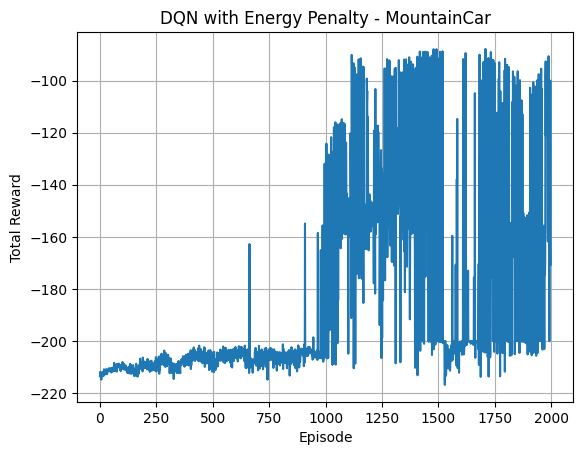

In [ ]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

# Set up environment
env = gym.make("MountainCar-v0", render_mode=None)  # Gym 0.26+ uses new API by default

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Neural Network Model
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.net(x)

# Hyperparameters
episodes = 2000
gamma = 0.99
epsilon = 1.0
epsilon_decay = 0.995
min_epsilon = 0.01
lr = 1e-3
batch_size = 64
memory_size = 10000
target_update_freq = 10

# Initialize components
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
policy_net = DQN(state_dim, action_dim).to(device)
target_net = DQN(state_dim, action_dim).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=lr)
loss_fn = nn.MSELoss()
memory = deque(maxlen=memory_size)

# ε-greedy action selection
def select_action(state, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()
    with torch.no_grad():
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        return policy_net(state).argmax().item()

# Training function
def train_step():
    if len(memory) < batch_size:
        return

    batch = random.sample(memory, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)

    states = torch.FloatTensor(states).to(device)
    actions = torch.LongTensor(actions).unsqueeze(1).to(device)
    rewards = torch.FloatTensor(rewards).unsqueeze(1).to(device)
    next_states = torch.FloatTensor(next_states).to(device)
    dones = torch.FloatTensor(dones).unsqueeze(1).to(device)

    q_values = policy_net(states).gather(1, actions)
    next_q = target_net(next_states).max(1)[0].unsqueeze(1)
    expected_q = rewards + gamma * next_q * (1 - dones)

    loss = loss_fn(q_values, expected_q)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Training loop
reward_history = []

for episode in range(episodes):
    state, _ = env.reset()
    total_reward = 0

    for t in range(200):  # Limit steps
        action = select_action(state, epsilon)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        # Apply energy penalty for pushing (left/right)
        if action != 0:
            reward -= 0.1

        memory.append((state, action, reward, next_state, done))
        train_step()

        state = next_state
        total_reward += reward
        if done:
            break

    epsilon = max(min_epsilon, epsilon * epsilon_decay)
    reward_history.append(total_reward)

    if episode % target_update_freq == 0:
        target_net.load_state_dict(policy_net.state_dict())

    if episode % 25 == 0:
        print(f"Episode {episode}, Total Reward: {total_reward:.2f}, Epsilon: {epsilon:.3f}")

# Plotting
plt.plot(reward_history)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQN with Energy Penalty - MountainCar")
plt.grid()
plt.show()


<ipython-input-2-95902a15b3eb>:72: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  states = torch.FloatTensor(states).to(device)


Episode 0, Reward: -213.60, Epsilon: 0.995
Episode 25, Reward: -210.70, Epsilon: 0.878
Episode 50, Reward: -210.00, Epsilon: 0.774
Episode 75, Reward: -210.50, Epsilon: 0.683
Episode 100, Reward: -211.20, Epsilon: 0.603
Episode 125, Reward: -210.70, Epsilon: 0.532
Episode 150, Reward: -210.50, Epsilon: 0.469
Episode 175, Reward: -212.90, Epsilon: 0.414
Episode 200, Reward: -210.20, Epsilon: 0.365
Episode 225, Reward: -212.90, Epsilon: 0.322
Episode 250, Reward: -213.70, Epsilon: 0.284
Episode 275, Reward: -214.00, Epsilon: 0.251
Episode 300, Reward: -211.00, Epsilon: 0.221
Episode 325, Reward: -213.20, Epsilon: 0.195
Episode 350, Reward: -213.70, Epsilon: 0.172
Episode 375, Reward: -214.10, Epsilon: 0.152
Episode 400, Reward: -196.10, Epsilon: 0.134
Episode 425, Reward: -208.80, Epsilon: 0.118
Episode 450, Reward: -210.30, Epsilon: 0.104
Episode 475, Reward: -209.60, Epsilon: 0.092


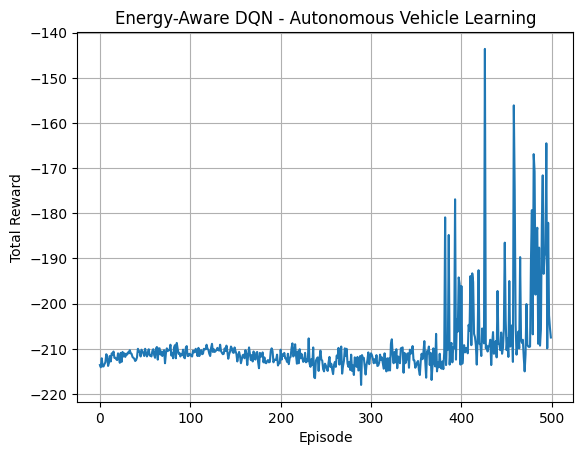

🎞️ Video saved as: autonomous_vehicle_learning.mp4 | Final Reward: -174.00


In [ ]:
# Install packages (run this once in Colab/terminal)
# !pip install gym==0.26.2 numpy==1.23.5 torch==2.0.1 matplotlib imageio

import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
import imageio

# Initialize environment (with rendering support)
env = gym.make("MountainCar-v0", render_mode="rgb_array")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Deep Q-Network
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.model(x)

# Hyperparameters
episodes = 500
gamma = 0.99
epsilon = 1.0
epsilon_decay = 0.995
min_epsilon = 0.01
lr = 1e-3
batch_size = 64
memory_size = 10000
target_update_freq = 10

# Initialize models and memory
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
policy_net = DQN(state_dim, action_dim).to(device)
target_net = DQN(state_dim, action_dim).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=lr)
loss_fn = nn.MSELoss()
memory = deque(maxlen=memory_size)

# ε-greedy action selection
def select_action(state, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()
    with torch.no_grad():
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        return policy_net(state_tensor).argmax().item()

# Train from experience
def train():
    if len(memory) < batch_size:
        return

    batch = random.sample(memory, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)

    states = torch.FloatTensor(states).to(device)
    actions = torch.LongTensor(actions).unsqueeze(1).to(device)
    rewards = torch.FloatTensor(rewards).unsqueeze(1).to(device)
    next_states = torch.FloatTensor(next_states).to(device)
    dones = torch.FloatTensor(dones).unsqueeze(1).to(device)

    q_vals = policy_net(states).gather(1, actions)
    next_q = target_net(next_states).max(1)[0].unsqueeze(1)
    expected_q = rewards + gamma * next_q * (1 - dones)

    loss = loss_fn(q_vals, expected_q)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Track training rewards
reward_history = []

for episode in range(episodes):
    state, _ = env.reset()
    total_reward = 0

    for _ in range(200):  # step limit
        action = select_action(state, epsilon)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        # Penalize energy use (non-zero actions)
        if action != 0:
            reward -= 0.1

        memory.append((state, action, reward, next_state, done))
        train()
        state = next_state
        total_reward += reward

        if done:
            break

    epsilon = max(min_epsilon, epsilon * epsilon_decay)
    reward_history.append(total_reward)

    if episode % target_update_freq == 0:
        target_net.load_state_dict(policy_net.state_dict())

    if episode % 25 == 0:
        print(f"Episode {episode}, Reward: {total_reward:.2f}, Epsilon: {epsilon:.3f}")

# Plot training progress
plt.plot(reward_history)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Energy-Aware DQN - Autonomous Vehicle Learning")
plt.grid()
plt.show()

# 🎥 Record video of trained agent
def record_video(filename="autonomous_vehicle_learning.mp4"):
    state, _ = env.reset()
    frames = []
    total_reward = 0

    for _ in range(200):
        frame = env.render()  # RGB frame
        frames.append(frame)

        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            action = policy_net(state_tensor).argmax().item()

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        total_reward += reward

        state = next_state
        if done:
            break

    imageio.mimsave(filename, frames, fps=30)
    print(f"🎞️ Video saved as: {filename} | Final Reward: {total_reward:.2f}")

record_video("autonomous_vehicle_learning.mp4")


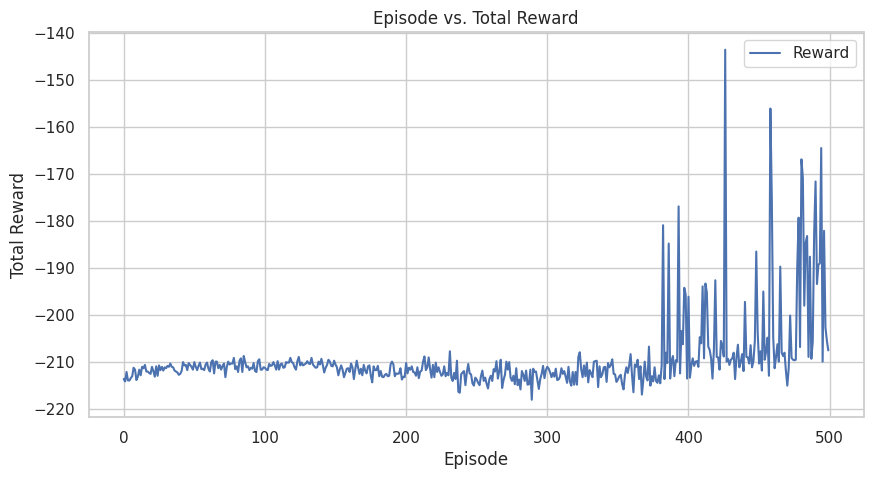

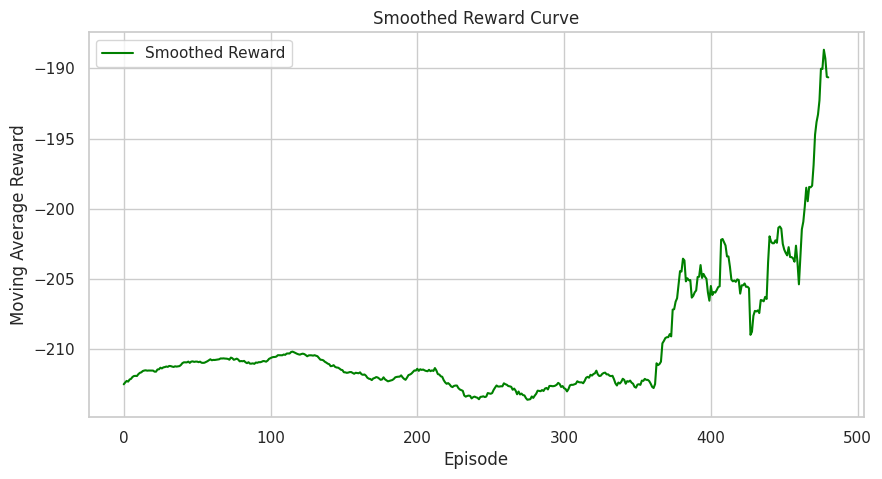

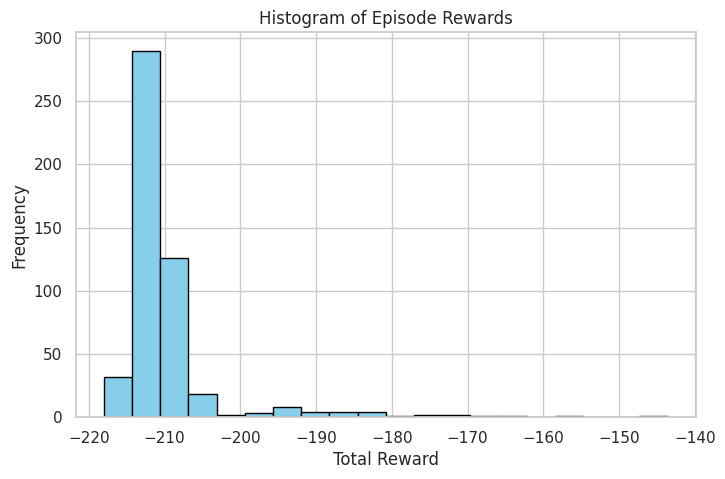

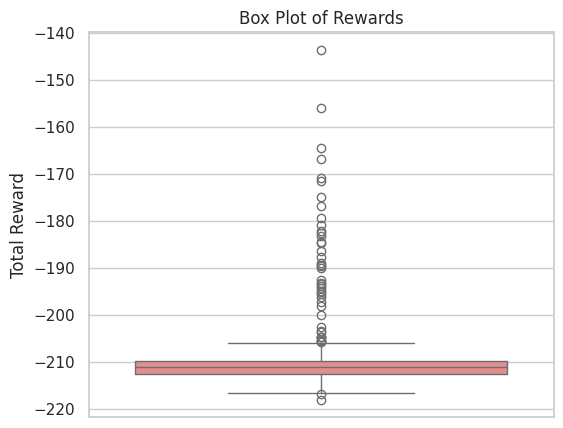

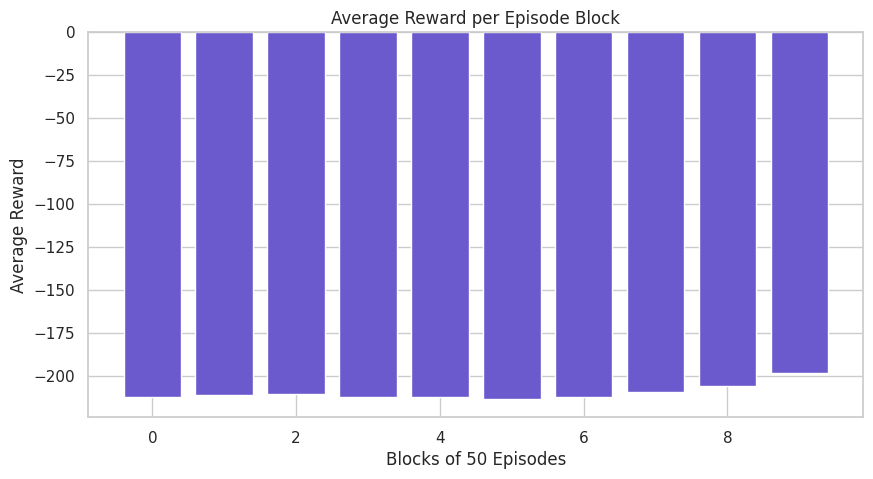

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure Seaborn style
sns.set(style="whitegrid")

# Moving average function
def moving_average(data, window_size=10):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# 1. Line chart: Total reward per episode
plt.figure(figsize=(10, 5))
plt.plot(reward_history, label='Reward')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Episode vs. Total Reward')
plt.legend()
plt.show()

# 2. Smoothed line chart (moving average)
plt.figure(figsize=(10, 5))
smoothed = moving_average(reward_history, window_size=20)
plt.plot(smoothed, color='green', label='Smoothed Reward')
plt.xlabel('Episode')
plt.ylabel('Moving Average Reward')
plt.title('Smoothed Reward Curve')
plt.legend()
plt.show()

# 3. Histogram of rewards
plt.figure(figsize=(8, 5))
plt.hist(reward_history, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Total Reward')
plt.ylabel('Frequency')
plt.title('Histogram of Episode Rewards')
plt.show()

# 4. Boxplot
plt.figure(figsize=(6, 5))
sns.boxplot(data=reward_history, color='lightcoral')
plt.title('Box Plot of Rewards')
plt.ylabel('Total Reward')
plt.show()

# 5. Bar chart of average reward per 50 episodes
block_size = 50
block_means = [np.mean(reward_history[i:i + block_size]) for i in range(0, len(reward_history), block_size)]

plt.figure(figsize=(10, 5))
plt.bar(range(len(block_means)), block_means, color='slateblue')
plt.xlabel(f'Blocks of {block_size} Episodes')
plt.ylabel('Average Reward')
plt.title('Average Reward per Episode Block')
plt.show()
